<a href="https://colab.research.google.com/github/HJKQWE/Project_DL_Fashion_MNIST/blob/main/Project_DL_Fashion_MNIST_%D0%93%D1%83%D1%80%D0%BE%D0%B2%D0%B0_%D0%AE%D0%BB%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [ ]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Currently logged in as: gret-ell (ready_go). Use `wandb login --relogin` to force relogin


True

In [ ]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt
import torchvision
from torch.autograd import Variable

# Фиксация случайного начального числа.
Почему важна правильная настройка случайного начального числа в экспериментах ML?

На практическом уровне будет трудно воспроизвести одни и те же результаты во всех прогонах модели — даже когда запускается один и тот же сценарий для одних и тех же обучающих данных. Это также может привести к проблемам при выяснении, связано ли изменение производительности с фактической моделью или модификацией данных или просто результатом новой случайной выборки.

Для решения этих источников вариаций важной отправной точкой является полная видимость данных, кода и параметров модели, а также деталей среды, которые привели к конкретному результату. Этот уровень воспроизводимости уменьшит неожиданные отклонения прогонах и поможет отлаживать эксперименты по машинному обучению.

“Начальное число” является отправной точкой для последовательности, и гарантия заключается в том, что если начать с того же начального числа, вы получите ту же последовательность чисел. Тщательно задавая случайное начальное число в вашем конвейере, можно добиться воспроизводимости.

Для этого:
1. Установим начальное значение
```
seed_value= 2022 # Например
```

2. Установим переменную среды `PYTHONHASHSEED` с фиксированным значением
```
import os
os.environ['PYTHONHASHSEED']=str (seed_value)
```

3. Установим псевдослучайный генератор `numpy` с фиксированным значением
```
import numpy как np
np.random.seed(seed_value)
```

4. Фиксируем генератор случайных чисел pytorch
```
torch.manual_seed(seed)
```

5. Фиксируем генератор случайных чисел для GPU

```
torch.cuda.manual_seed(seed)
```


[**PYTHONHASHSEED**](https://docs.python.org/3/using/cmdline.html#envvar-PYTHONHASHSEED)

Если эта переменная не задана или установлена на random, случайное значение используется для заполнения хэшей объектов str и bytes.

Если PYTHONHASHSEED задано целочисленное значение, оно используется как фиксированное начальное значение для генерации хэша() типов, охватываемых рандомизацией хэша.

Его цель - разрешить повторяемое хеширование, например, для самотестирования самого интерпретатора, или разрешить кластеру процессов python совместно использовать хэш-значения.

Целое число должно быть десятичным числом в диапазоне [0,4294967295]. Указание значения 0 отключит рандомизацию хэша.




In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей. PYTHONHASHSEED переменная среды с фиксированным значением
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU

Выпишем все классы для последующего использования. 

Инструменты Weights & Biases позволяют легко и быстро отслеживать эксперименты, визуализировать результаты, выявлять регрессии и многое другое. Проще говоря, веса и смещения позволяют быстрее создавать более качественные модели и легко делиться результатами с коллегами.

Для проверки и настройки сервиса Weights & Biases, мной проведена регистрация в сервисе.

api - представлен на стартовой странице, после завершения регистрации.

project - создан академический проект с возможностью работать в группе.

entity - логин входа в сервис.

wandb = True или False, зависит от того хотим ли использовать сервис или нет.

**Примечание:**
num_workers прилось поставить равное 2, так как выходило предупреждение.

 "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg("

In [ ]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "c46873158d9b17d359eb43bbe31308d56f8ce3d4"# вписать свой API Wandb  
  project = "ready_go"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "gret-ell"# ввести свой логин
  wandb = True # флаг использования Wandb
  num_epochs = 10 # количество эпох прогона обучения модели
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 2 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости фиксируем случайное число
  classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # классы датасета
  



In [ ]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [ ]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# Загружаем данные.

[CLASS:FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) (

**root**= 'str' - Корневой каталог набора данных, в котором датасет существует ,

 **train**: bool = True - Если True, создает набор данных из train-images-idx3-ubyte, в противном случае из t10k-images-idx3-ubyte, 
 
 **transform**: Optional[Callable] = None - функция / преобразование, которая принимает PIL-изображение и возвращает преобразованную версию. Например, transforms.RandomCrop,
 
  **target_transform**: Optional [Callable] = None - функция / преобразование, которая принимает цель и преобразует ее, 
  
  **download**: bool = False - Если True, загружает набор данных из Интернета и помещает его в корневой каталог. Если набор данных уже загружен, он не загружается повторно)

  [TORCH.UTILS.DATA](https://pytorch.org/docs/stable/data.html)

  В основе утилиты загрузки данных PyTorch лежит torch.utils.data.DataLoader класс. Он представляет собой итерацию Python по набору данных с поддержкой.

  Эти параметры настраиваются аргументами конструктора a DataLoader, который имеет обозначение:

DataLoader(dataset - датасет, подлежащий загрузке, 

batch_size - размер пакета, который будет подаваться в нейросеть, 

shuffle - перемешивать или подавать последовательно пакеты, 

num_workers - количество активных процессоров. Чтобы избежать блокировки вычислительного кода при загрузке данных, PyTorch предоставляет простой переключатель для выполнения многопроцессорной загрузки данных, просто установив аргумент num_workers до положительного целого числа, 

pin_memory - Обычно не рекомендуется возвращать тензоры CUDA при многопроцессорной загрузке из-за многих тонкостей использования CUDA и совместного использования тензоров CUDA при многопроцессорной обработке (см. [CUDA в разделе многопроцессорная обработка](https://pytorch.org/docs/stable/notes/multiprocessing.html#multiprocessing-cuda-note)). Вместо этого рекомендуется использовать автоматическое закрепление памяти (т.е. настройку pin_memory=True), что обеспечивает быструю передачу данных на графические процессоры с поддержкой CUDA. Копирование с хоста на графический процессор выполняется намного быстрее, когда они создаются из закрепленной (заблокированной по страницам) памяти.)

и другие, которые ожно найти в документации.

Ранее мы загрузили изображения и сразу их трансформировали. Но можно сделать и вот так:


```

train_set = torchvision.datasets.FashionMNIST("data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
                                            
  
```

  
   

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([64, 1, 28, 28])

In [ ]:
len(train_data)

60000

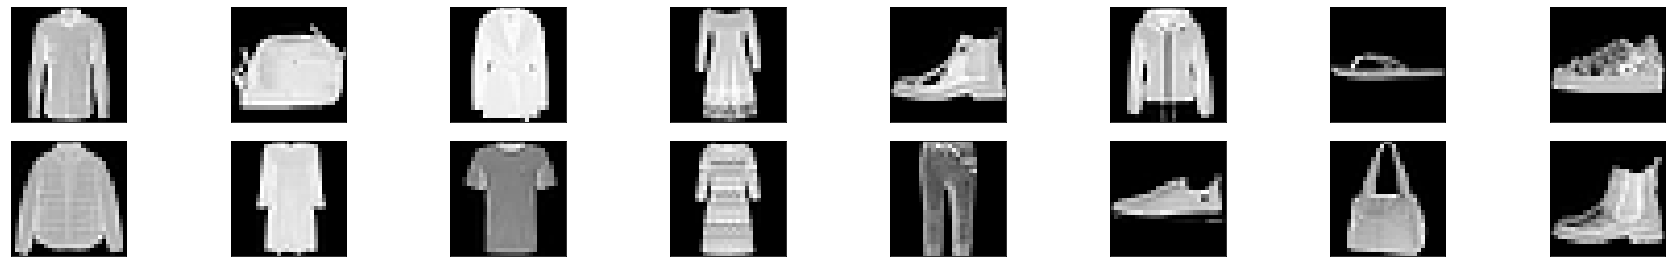

In [ ]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
  plt.subplot(2, 8, idx+1)
  plt.tight_layout()
  plt.imshow(images[idx][0], cmap='gray')
  plt.xticks([])
  plt.yticks([])


Отображение некоторых изображений с использованием метода matplotlib imshow().

9


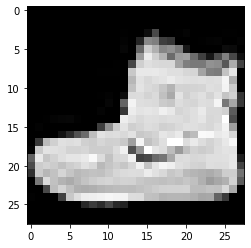

In [ ]:
image, label = next(iter(train_data))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_data, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

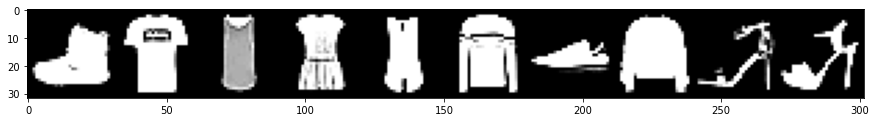

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

# Создаем полносвязаннную нейронную сеть. 

Создаем класс модели (в нашем случае My_Net)

Он наследует nn.Module, который является суперклассом для всех нейронных сетей в Pytorch.
Наша нейронная сеть имеет следующие слои:

1. Два последовательных слоя, каждый из которых состоит из следующих слоев-
  - Слой свертки, который имеет размер kernel size 3 * 3, padding = 1 (zero_padding) в 1-м слое и padding = 0 во втором. Шаг 1 в обоих слоях.
  - Слой Batch Normalization.
  - Функция активации: ReLU.
  - Max Pooling слой с размером ядра 2 * 2 и шагом 2.
    * Выровняем (Flatten) выходные данные для получения dense layer слоя (он же полностью связанный слой).
    * 3 Полностью "connected layer" слоя с различными функциями ввода-вывода.
    * 1 "Dropout" слой, который имеет вероятность класса p = 0,25.
2. Вся функциональность задана в методе forward, который определяет прямой проход CNN.
3. Наше входное изображение меняется следующим образом:
  - Первый слой "Convulation layer": входные данные: 28 * 28 * 3 , вывод: 28 * 28 * 32
  - Первый "Max Pooling layer" : входные данные: 28 * 28 * 32 , вывод: 14 * 14 * 32
  - Второй слой "Convulation layer" : входные данные : 14 * 14 * 32 , вывод: 12 * 12 * 64
  - Второй "Max Pooling layer": 12 * 12 * 64 , вывод: 6 * 6 * 64
4. Конечный "fully connected layer" слой имеет 10 выходных функций для 10 типов одежды.

In [ ]:
class My_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):

        super(My_Net, self).__init__() # super class constructor

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


In [ ]:
model = My_Net()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
print(model) # посмотрим на нашу модель

My_Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.SGD(params=model.parameters(),
                           lr=0.01)

In [ ]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0
    
    n_ex = len(train_loader)
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))
    
    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [ ]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    
    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [ ]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))
  
    use_cuda = torch.cuda.is_available() # проверяем доступность GPU 

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # выделили устройство 
    
    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Feb 22 13:13:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |    592MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение. Цель - получить на тесте значение accuracy не менее 98%.

In [ ]:
main(model)

wandb: Currently logged in as: gret-ell. Use `wandb login --relogin` to force relogin



Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 938/938 [00:15<00:00, 59.26it/s]


Train set: Average loss: 0.4133, Accuracy: 81%


Test set: Average loss: 0.3646, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:14<00:00, 66.41it/s]



Train set: Average loss: 0.1538, Accuracy: 88%
Test set: Average loss: 0.2667, Accuracy: 88%

Epoch: 3


100%|██████████| 938/938 [00:14<00:00, 65.97it/s]


Train set: Average loss: 0.1655, Accuracy: 89%


Test set: Average loss: 0.2397, Accuracy: 89%

Epoch: 4


100%|██████████| 938/938 [00:14<00:00, 64.75it/s]


Train set: Average loss: 0.6791, Accuracy: 90%


Test set: Average loss: 0.2535, Accuracy: 88%

Epoch: 5


100%|██████████| 938/938 [00:13<00:00, 67.05it/s]


Train set: Average loss: 0.3952, Accuracy: 91%


Test set: Average loss: 0.2619, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:14<00:00, 65.32it/s]


Train set: Average loss: 0.1378, Accuracy: 91%


Test set: Average loss: 0.1994, Accuracy: 90%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 61.48it/s]



Train set: Average loss: 0.2919, Accuracy: 92%
Test set: Average loss: 0.2874, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:14<00:00, 63.50it/s]


Train set: Average loss: 0.2064, Accuracy: 92%


Test set: Average loss: 0.1983, Accuracy: 90%

Epoch: 9


100%|██████████| 938/938 [00:13<00:00, 67.03it/s]


Train set: Average loss: 0.1301, Accuracy: 92%


Test set: Average loss: 0.1792, Accuracy: 90%

Epoch: 10


100%|██████████| 938/938 [00:13<00:00, 67.44it/s]


Train set: Average loss: 0.2569, Accuracy: 93%


Test set: Average loss: 0.2100, Accuracy: 89%
Training is end!


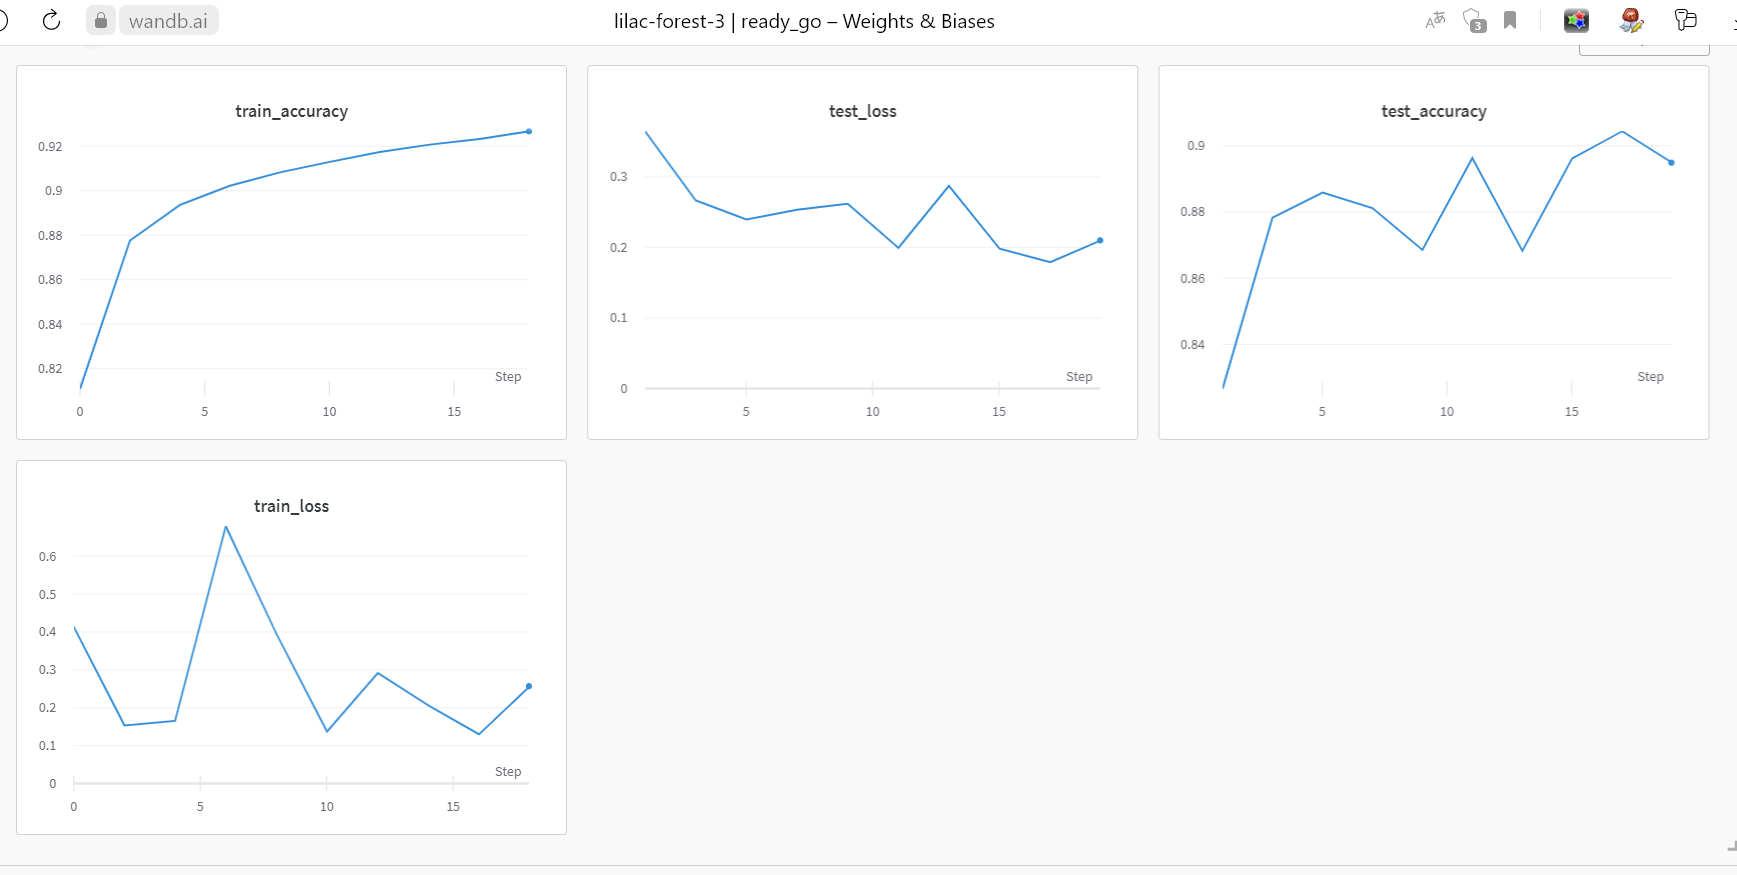

Пробуем другие оптимизаторы.

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(),
                           lr=0.01)

In [ ]:
main(model)

test_accuracy,▁▆▆▆▅▇▅▇█▇
test_loss,█▄▃▄▄▂▅▂▁▂
train_accuracy,▁▅▆▇▇▇▇███
train_loss,▅▁▁█▄▁▃▂▁▃
test_accuracy,0.8949
test_loss,0.21002
train_accuracy,0.9267
train_loss,0.25694



Epoch: 1


100%|██████████| 938/938 [00:15<00:00, 61.50it/s]


Train set: Average loss: 0.3481, Accuracy: 80%


Test set: Average loss: 0.3882, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 61.35it/s]


Train set: Average loss: 0.2506, Accuracy: 88%


Test set: Average loss: 0.2577, Accuracy: 87%

Epoch: 3


100%|██████████| 938/938 [00:16<00:00, 57.73it/s]


Train set: Average loss: 0.2708, Accuracy: 89%


Test set: Average loss: 0.2343, Accuracy: 89%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 60.69it/s]


Train set: Average loss: 0.9327, Accuracy: 90%


Test set: Average loss: 0.2518, Accuracy: 89%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 61.40it/s]


Train set: Average loss: 0.3477, Accuracy: 90%


Test set: Average loss: 0.2380, Accuracy: 89%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 59.30it/s]


Train set: Average loss: 0.0567, Accuracy: 90%


Test set: Average loss: 0.2220, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 61.80it/s]


Train set: Average loss: 0.3462, Accuracy: 89%


Test set: Average loss: 0.2870, Accuracy: 89%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 60.10it/s]


Train set: Average loss: 0.4157, Accuracy: 89%


Test set: Average loss: 0.3362, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 53.45it/s]


Train set: Average loss: 0.2563, Accuracy: 88%


Test set: Average loss: 0.3479, Accuracy: 87%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 61.79it/s]



Train set: Average loss: 0.4738, Accuracy: 88%
Test set: Average loss: 0.3138, Accuracy: 87%
Training is end!


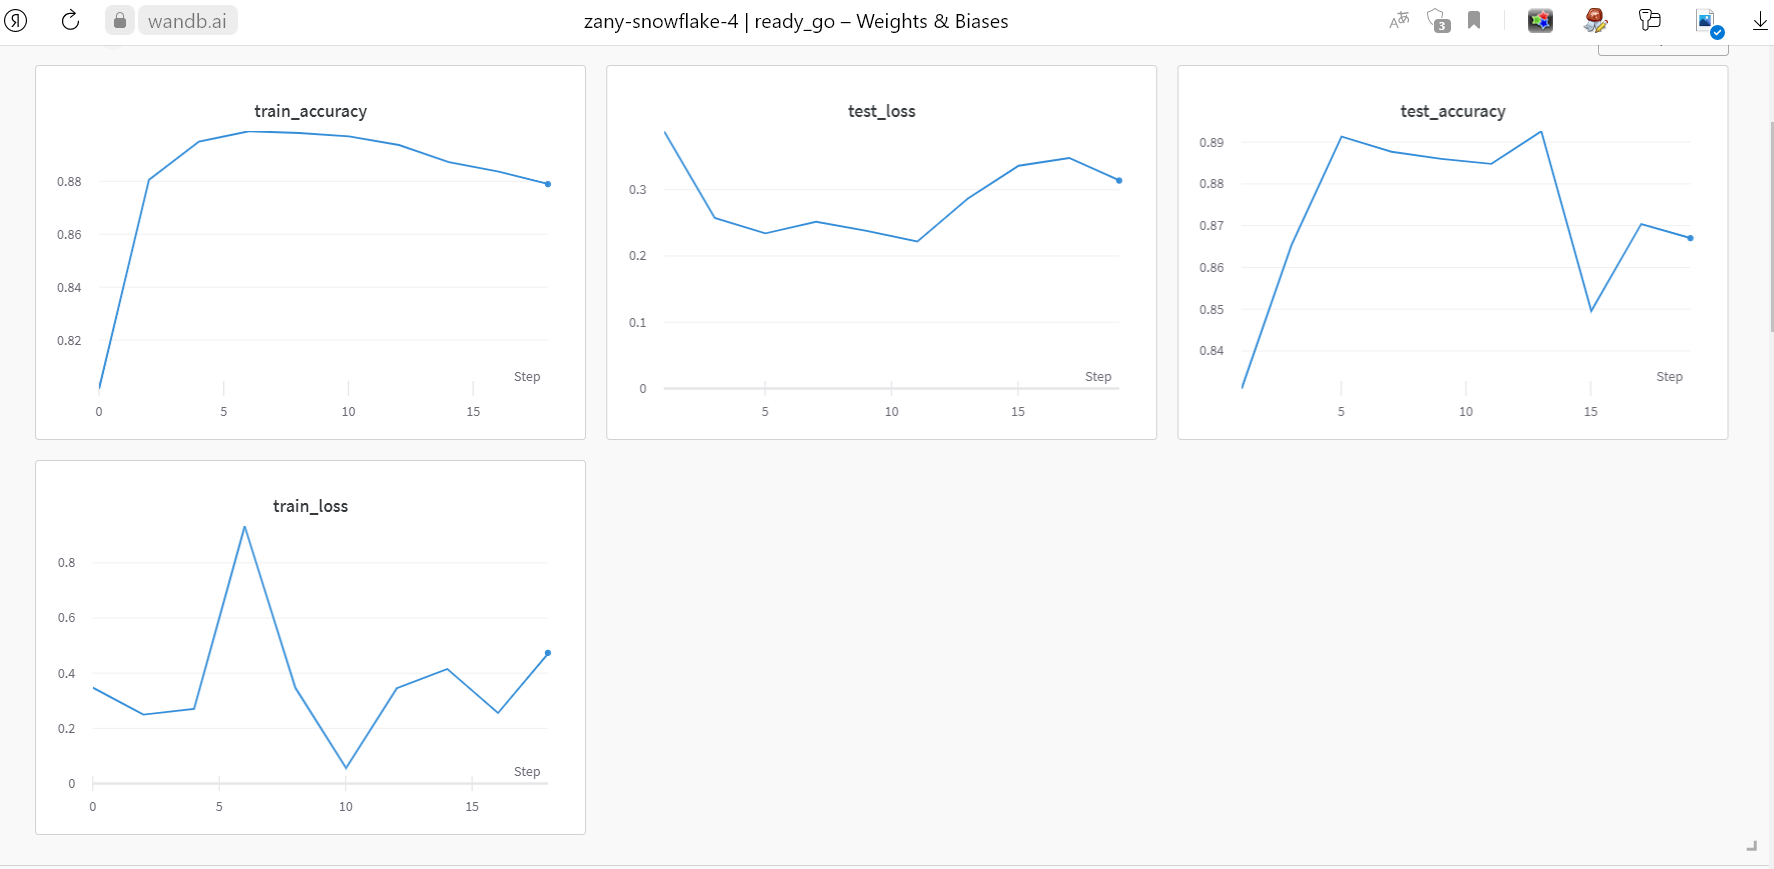

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 69.73%
Accuracy of Trouser: 95.90%
Accuracy of Pullover: 86.12%
Accuracy of Dress: 80.37%
Accuracy of Coat: 76.92%
Accuracy of Sandal: 98.05%
Accuracy of Shirt: 79.25%
Accuracy of Sneaker: 87.79%
Accuracy of Bag: 97.51%
Accuracy of Ankle Boot: 98.19%


Выводы:

Количество эпох велико - модель переобучается. Наименьшие ошибки были на 6-й эпохе.

У SGD: 

Train set: Average loss: 0.1378, Accuracy: 91%

Test set: Average loss: 0.1994, Accuracy: 90%

У Adam:

Train set: Average loss: 0.0567, Accuracy: 90%

Test set: Average loss: 0.2220, Accuracy: 88%

Существует способ получить доступ к каждому изучаемому параметру модели вместе с их именами. Кстати, torch.nn.Parameter является подклассом Tensor, который при использовании с torch.nn.Module автоматически добавляется в список его параметров

In [ ]:
for name, param in model.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=====')
# Печать state_dict оптимизатора
print("state_dict оптимизатора:")
for  var_name  in  optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    print('=====')

name:  layer1.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32, 1, 3, 3])
param.requires_grad:  True
=====
name:  layer1.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32])
param.requires_grad:  True
=====
name:  layer1.1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32])
param.requires_grad:  True
=====
name:  layer1.1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32])
param.requires_grad:  True
=====
name:  layer2.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([64, 32, 3, 3])
param.requires_grad:  True
=====
name:  layer2.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([64])
param.requires_grad:  True
=====
name:  layer2.1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([64])
param.requires_grad:  True
=====
name:  layer2.1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([64])
param.requires

# Сохранение весов из Google Colab Google Disk

Подробно правила указаны [здесь](https://colab.research.google.com/drive/1CN7JxLA_Qk1Clc4CM75rSAqIlUKIF8xZ#scrollTo=0bLRwiCEEkms)



In [ ]:
model_save_name = 'model'
PATH = F'/content/drive/MyDrive/model/{model_save_name}'


In [ ]:
torch.save({
            'epoch': 6,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)